# Introduction to PySpark and Application in Exploratory Data Analysis

## Apache Spark
Due to the invention of the internet and the increasing 3V (volume, variety, and velocity) of data, data scientists and engineers nowadays need to deal with terabytes of data in a more distributed way to facilitate the speed of the data science pipeline. In this tutorial, I'm going to introduce Apache Spark, an open-source cluster-computing framework, and its application in big data processing as well as exploratory data analysis. Spark provides APIs for several high-level programming languages including Python and Scala so that the programmers could easily develop MapReduce data processing programs at their convenience. The major advantage of Spark over tranditional MapReduce is that it supports in-memory computing, which could significantly improve the runtime performance. Spark also provides advanced libraries such as Spark MLlib and GraphX for distributed machine learning and graph processing on top of Apache Spark. After introducing the basics of Spark, I'll briefly introduce the Latent Dirichlet Allocation topic modeling functionality in PySpark MLlib in the last section of this tutorial.

### Package Installation

In this tutorial, we are going to use several different libraries for data processing and visualizations.
Most of the libraries like findspark, csv, and seaborn could be installed using pip.
```
pip install package_name
```

As for Apache Spark, you can follow <a href="https://medium.com/@GalarnykMichael/install-spark-on-mac-pyspark-453f395f240b">this tutorial</a> for installing it on your computer.


### PySpark Initiatialization

After successfully install PySpark, you can use findspark package and its ```init()``` method to automatically configure the path of PySpark and makes Spark on you system importable as a regular module.<br>

Introduction to findspark package:<br>
https://github.com/minrk/findspark<br>
https://pypi.python.org/pypi/findspark

In [1]:
import findspark
findspark.init()

```init()``` will make pyspark importable. After importing pyspark, we need to create a SparkContext object. SparkContext will serve as an entry point for accessing Spark functionalities and Spark cluster (if connected to a cluster). I'll use the Apache Spark version 2.2.1 in standalone mode for the sake of demo to conduct this tutorial.

In [2]:
import random
import csv
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import collections
import re
import seaborn as sns
import pyspark
sc = pyspark.SparkContext(appName="test")
sc

<SparkContext master=local[*] appName=test>

### Resilient Distributed Datasets (RDDs)
In Spark, the basic unit of data trunk is called "Resilient Distributed Dataset" (RDD). RDD enables the user to split the data into partitions, then Spark could distributes the partitions into multiple workers to run operations in parallel. By making ```transformations``` and ```actions``` on data, Spark could work with a large amount of data in a distributed, MapReduce fashion. There are two ways of generating a RDD in Spark, and here I demonstrate the first one: parallelize a Python collection (iterable) to construct a RDD.

In [3]:
# the optional "numSlices" parameter of parallelize could be used to partition data
# into numSlices of pieces. Default value is None
data = sc.parallelize([1,2,3,4,5], numSlices=None)
print("The length of the data is %d" % data.count())
saved = data.collect()

print("Type of the parallelized data is %s" % type(data))
print("Type of collected data is %s " % type(saved))
print("Processed data is %s" % saved)

The length of the data is 5
Type of the parallelized data is <class 'pyspark.rdd.RDD'>
Type of collected data is <class 'list'> 
Processed data is [1, 2, 3, 4, 5]


The second way to generate a RDD is read from an external file. Here I created a toy text file called ```data.txt``` and read the text using PySpark.

In [4]:
fileData = sc.textFile("data.txt")
savedFile = fileData.collect()

print("The length of the fileData is %d" % fileData.count())
print("Type of collected data is %s " % type(savedFile))
print("Processed data is %s" % fileData.collect())

The length of the fileData is 4
Type of collected data is <class 'list'> 
Processed data is ['My heart is in the work', 'But I have no idea where my mind is', "Because I'm a workaholic", 'CMU rules the world YOOO!']


## Basic operations on RDDs
In Spark, there are two kinds of operations that user could perform on a RDD.<br>
```Transformations``` will apply certain functions to the RDD and transform the data into the user-specified formats or values.<br>
```Actions``` will compute the result of the RDD based on a certain criteria and return the result to the driver program.<br>

### Transformation
The transformation in Spark is "lazy", meaning that the transformation operation won't fire immediately, but only "remembered" by the RDD and be executed only if an action is requested. This feature significantly increase the efficiency of Spark programs because the program doesn't need to compute the large dataset if no one is trying to request the result of a computation on it.

First, I'll show a common operation ```map(func)```, which will map the function to each element to transform a list. There are two common ways to pass in the transformation function to the data. You can either perform a transformation using a user-defined or built-in function, or using lambda expression (which is extremely convenient for a Python programmer). Note that we can chain-up the transformation upon a RDD. 

In [5]:
# split the input sentence by space
def splitWord(sentence):
    return sentence.split()

print(fileData.map(splitWord).collect())
# print out the word counts of each sentence
print(fileData.map(str.split).map(lambda x : len(x)).collect())

[['My', 'heart', 'is', 'in', 'the', 'work'], ['But', 'I', 'have', 'no', 'idea', 'where', 'my', 'mind', 'is'], ['Because', "I'm", 'a', 'workaholic'], ['CMU', 'rules', 'the', 'world', 'YOOO!']]
[6, 9, 4, 5]


In [6]:
# perform a transformation using lambda expression
splitedRDD = (fileData.map(lambda x : x.split())
                      .map(lambda x : x + ["asdasd"]))
print(splitedRDD.collect())

[['My', 'heart', 'is', 'in', 'the', 'work', 'asdasd'], ['But', 'I', 'have', 'no', 'idea', 'where', 'my', 'mind', 'is', 'asdasd'], ['Because', "I'm", 'a', 'workaholic', 'asdasd'], ['CMU', 'rules', 'the', 'world', 'YOOO!', 'asdasd']]


Other interesting and powerful operations like flatMap, filter, and randomSample are also very useful for transforming data for further analysis.
```flatMap(func)``` will process the input and output the processed data as a sequence but not a single list.

In [7]:
testRDD = sc.parallelize(["Hi, I'm Tom", "Who are you?"])
print("Result of map: %s" % testRDD.map(lambda x : x.split()).collect())
print("Result of flatMap: %s" % testRDD.flatMap(lambda x : x.split()).collect())

Result of map: [['Hi,', "I'm", 'Tom'], ['Who', 'are', 'you?']]
Result of flatMap: ['Hi,', "I'm", 'Tom', 'Who', 'are', 'you?']


```filter(func)``` could be used to select elements on which the return value is true based on the criteria provided by the arg function.

In [8]:
testNumRDD = sc.parallelize(range(1000))
threeMultiples = testNumRDD.filter(lambda x : x % 3 == 0).collect()
print("The first and last multiples of three in 1000 are: %s and %s" % (threeMultiples[0], threeMultiples[-1]))
print("Number of multiples of three is %d" % len(threeMultiples))

The first and last multiples of three in 1000 are: 0 and 999
Number of multiples of three is 334


```randomSplit(weights, seed)``` could randomly partition the data into multiple chunks with different size based on the weights argument

In [9]:
weights = [10, 20, 30]
seed = 0
rdd1, rdd2, rdd3 = testNumRDD.randomSplit(weights, seed)
print("Length of all data: %d" % len(rdd1.collect() + rdd2.collect() + rdd3.collect()))
print("Length of rdd1 is %d, length of rdd2 is %d, length of rdd3 is %d." % (rdd1.count(), rdd2.count(), rdd3.count()))

Length of all data: 1000
Length of rdd1 is 157, length of rdd2 is 314, length of rdd3 is 529.


```cartesian(otherRDD)``` could be used to generate cartesian product of two RDD

In [10]:
testRDD1 = sc.parallelize([1,2,3])
testRDD2 = sc.parallelize(["a", "b", "c"])
cartesianProductRDD = testRDD1.cartesian(testRDD2).collect()
print("The cartesian product of the two RDD: %s" % cartesianProductRDD)
print("The length is %d, which is the product of the length of the two RDDs (%d * %d)" % (len(cartesianProductRDD), testRDD1.count(), testRDD2.count()))

The cartesian product of the two RDD: [(1, 'a'), (1, 'b'), (1, 'c'), (2, 'a'), (2, 'b'), (2, 'c'), (3, 'a'), (3, 'b'), (3, 'c')]
The length is 9, which is the product of the length of the two RDDs (3 * 3)


### Actions
Another category of operations in Spark is called "actions". Actions will be used to trigger the lazy transformation the RDD "remembered" and return the processed data to the user (driver program). One of the most common action is ```collect()```, which is simply retrieve the data after applying transformations on RDD.

Some basic but useful actions include ```first()``` and ```count()```, which returns the first element and the element count of RDD, respectively.

In [11]:
dataRDD = sc.parallelize([1, 2, 3, 4, 5])
addFiveRDD = dataRDD.map(lambda x : x + 5)

print(addFiveRDD.collect())
print("The first element in the result is %d" % addFiveRDD.first())
print("The number of elements in the result is %d" % addFiveRDD.count())
print("The sum of the result is %d" % addFiveRDD.reduce(lambda x, y : x + y))

[6, 7, 8, 9, 10]
The first element in the result is 6
The number of elements in the result is 5
The sum of the result is 40


```take(n)``` and ```takeOrdered(n, [ordering])``` can take the first n elements in the RDD with or without order.

In [12]:
randomNumsRDD = sc.parallelize(random.sample(range(1000), 20))
print(randomNumsRDD.collect())
print(randomNumsRDD.take(10))
print(randomNumsRDD.takeOrdered(10))

[517, 154, 313, 814, 702, 754, 123, 6, 769, 497, 675, 839, 107, 770, 886, 671, 442, 143, 398, 962]
[517, 154, 313, 814, 702, 754, 123, 6, 769, 497]
[6, 107, 123, 143, 154, 313, 398, 442, 497, 517]


### Word Count
So we now have some knowledge about how to manipulate data in Spark, let's do some basic application like computing the word count in my test document. Like other data engineering tools, we can perform groupby operations in Spark as we are using SQL or Pandas Dataframe. Here I show the way to count frequency of each word. First, I create a list of all words using flatMap to flatten all the splitted sentences.

There are two common ways to do the key-value pairs counting. The first approach is grouping by the keys using ```groupByKey()``` then sum up the grouped values of each word.

Another MapReduce-like technique is using ```reduceByKey(func)``` to group the data then aggregate it using the function provided as the argument. Generally speaking, using reduceByKey would have better readability and performance than using groupByKey to do split-apply-combine if the user wants to do aggregation on data after grouping it.


In [13]:
wordPairs = (fileData.flatMap(str.split)
                     .map(lambda x : (x, 1)))

groupedPairs = wordPairs.groupByKey().map(lambda x : (x[0], sum(x[1]))).collect()
print(groupedPairs)
print()
reducedPairs = wordPairs.reduceByKey(lambda x, y : x + y)
reducedResult = reducedPairs.collect()
print(reducedResult)
print()
print("The groupedPairs and reducedPairs has the same result: %s" % (reducedResult == groupedPairs))

[('heart', 1), ('is', 2), ('in', 1), ('work', 1), ('But', 1), ('have', 1), ('no', 1), ('idea', 1), ('where', 1), ('mind', 1), ('Because', 1), ('rules', 1), ('world', 1), ('YOOO!', 1), ('My', 1), ('the', 2), ('I', 1), ('my', 1), ("I'm", 1), ('a', 1), ('workaholic', 1), ('CMU', 1)]

[('heart', 1), ('is', 2), ('in', 1), ('work', 1), ('But', 1), ('have', 1), ('no', 1), ('idea', 1), ('where', 1), ('mind', 1), ('Because', 1), ('rules', 1), ('world', 1), ('YOOO!', 1), ('My', 1), ('the', 2), ('I', 1), ('my', 1), ("I'm", 1), ('a', 1), ('workaholic', 1), ('CMU', 1)]

The groupedPairs and reducedPairs has the same result: True


# Exploratory Data Analysis using PySpark
After learning the basic operations of PySpark, let's do some exploratory data analysis to further strengthen our knowledge of the tool by applying it in a real world dataset. Exploratory data analysis (EDA) is a procedure that can be employed on a dataset to uncover interesting trends or statistical meaning underlying the data.
Here I'll use Youtube's top trending videos dataset, which acquired from Kaggle, and PySpark to perform EDA.

The dataset contains top trending video data in five different countries including USA, Great Britain, Germany, Canada, and France. I'm going to focus on the US data and its corresponding category IDs in the JSON file. Firstly, let's define two helper functions to help us to transform the CSV and json file into RDDs and dictionaries for further usage.

Due to the size limitation of size of the compressed file, you'll need to download the dataset if you wish to run the following code. You can find the youtube dataset here: <br>
https://www.kaggle.com/datasnaek/youtube-new

In [14]:
# load the data from CSV file to construct RDD
def fileToRDD(filePath):
    with open(filePath, "r") as f:
        csvReader = csv.reader(f)
        # extract header row and generate the column index mapping
        header = csvReader.__next__()
        headerMap = {value: index for index, value in enumerate(header)}
        data = [row for row in csvReader]
        dataRDD = sc.parallelize(data)
    return dataRDD, headerMap
            
# Generate categoryID : categoryName mapping dictionary
def getCategoryMap(filePath):
    with open(filePath, "r") as f:
        jsonData = json.load(f)["items"]
        categoriesMap = {elem["id"]: elem["snippet"]["title"] for elem in jsonData}
        catNameIDMap = {elem["snippet"]["title"]: elem["id"] for elem in jsonData}
    return categoriesMap, catNameIDMap

rdd, headerMap = fileToRDD("youtube-new/USvideos.csv")
categoriesMap, catNameIDMap = getCategoryMap("youtube-new/US_category_id.json")

## Visualization for Analysis
### Visualized Count of Categories and Tags Using Seaborn
After constructing the essential RDD and mappings of data fields, we can finally start the exploratory data analysis! Let's start with checking what categories are the most and least famous among the videos.

In [15]:
# Compute the number of each category in the top trending videos
categoryRDD = (rdd.map(lambda x: (categoriesMap[x[headerMap["category_id"]]], 1))
                  .reduceByKey(lambda x, y: x + y))
numOfCategories = categoryRDD.count()
print("Total category of the videos are %d" % numOfCategories)
mostPopularCats = categoryRDD.takeOrdered(3, lambda x: -x[1])
leastPopularCats = categoryRDD.takeOrdered(3, lambda x: x[1])
print("The most popular categories are %s" % mostPopularCats)
print("The least popular categories are %s" % leastPopularCats)

Total category of the videos are 16
The most popular categories are [('Entertainment', 5073), ('Music', 3211), ('Howto & Style', 2041)]
The least popular categories are [('Shows', 16), ('Nonprofits & Activism', 48), ('Travel & Events', 247)]


Now let's visualize the categoryRDD in category to the video number using Seaborn's barplot function. Seaborn is a matplotlib-based package which can make the graph more visually appealing. Here I plot the bar plot horizontally using seaborn's ```barplot``` function.
https://seaborn.pydata.org/generated/seaborn.barplot.html

In [16]:
# Helper function for plotting seaborn's barplot
def snsBarPlot(df, y, dpi):
    print(df)
    plt.figure(figsize=(8,6), dpi=dpi)
    ax = sns.barplot(x = "Number", y = y, data = df)

                 Category  Number
0           Entertainment    5073
1                   Music    3211
2           Howto & Style    2041
3         News & Politics    1866
4                  Comedy    1861
5          People & Blogs    1760
6    Science & Technology    1341
7        Film & Animation    1238
8                  Sports    1174
9               Education     912
10         Pets & Animals     558
11       Autos & Vehicles     339
12                 Gaming     280
13        Travel & Events     247
14  Nonprofits & Activism      48
15                  Shows      16


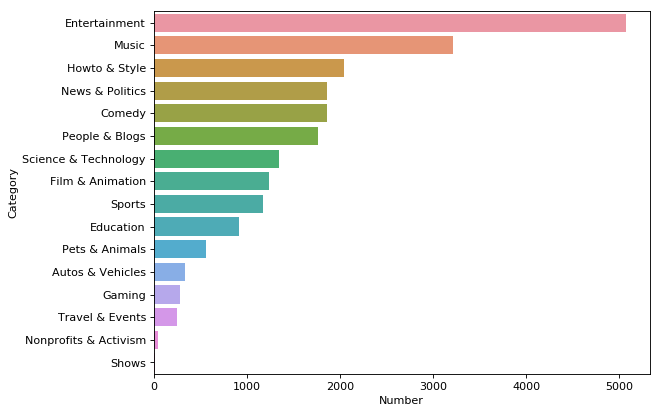

In [17]:
allCategory = sorted(categoryRDD.collect(), key = lambda x: -x[1])
cdf = pd.DataFrame(allCategory, columns=["Category", "Number"])
snsBarPlot(cdf, "Category", 80)

I believe it's not surprising that the most popular categories are about "Entertainment", "Music", and "Howto & Style". Another keypoint of understanding the dataset is to examine the tags of the videos. By examing tags, we might have some knowledge about the popular things in that period of time.

          Tag  Number
0       funny    2041
1      comedy    1878
2      [none]     978
3       music     857
4        news     836
5     trailer     711
6      how to     692
7         pop     671
8        food     666
9        2017     657
10      humor     657
11    science     653
12  celebrity     628
13        diy     615
14  christmas     581
15     review     579
16      video     569
17       2018     568
18  interview     565
19       live     561


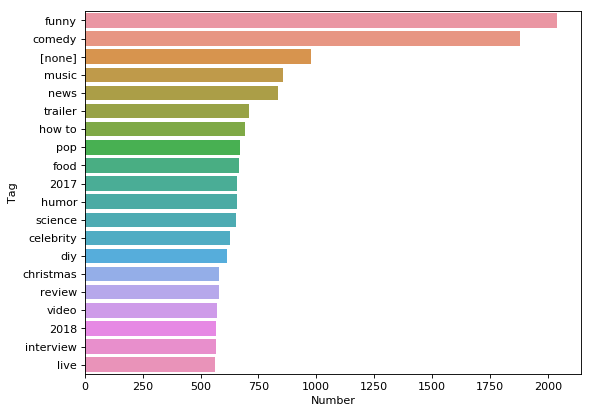

In [18]:
tagsRDD = (rdd.flatMap(lambda x: x[headerMap["tags"]].lower().replace('"', '').split("|"))
               .map(lambda x: (x, 1))
               .reduceByKey(lambda x, y : x + y))

top20Tags = tagsRDD.takeOrdered(20, lambda x: -x[1])
tagDF = pd.DataFrame(top20Tags, columns=["Tag", "Number"])
snsBarPlot(tagDF, "Tag", 80)


It seems like the tags has a trend that agrees with the count plot of the categories.

### Visualize "likes" and "dislike" Counts and Power Law
Next, we might want to take a look at how many "likes" and "dislikes" each video receives and check is there any correlation between number of votes and the amount of the videos.

In [19]:
likesRDD = rdd.map(lambda x: int(x[headerMap["likes"]])).collect()
dislikesRDD = rdd.map(lambda x: int(x[headerMap["dislikes"]])).collect()
viewsRDD = rdd.map(lambda x: int(x[headerMap["views"]])).collect()

Text(0,0.5,'Number of Videos')

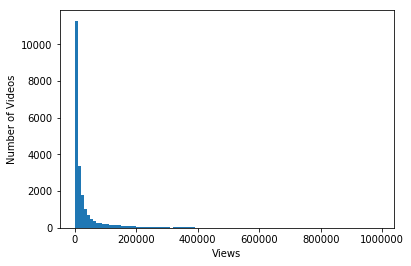

In [20]:
plt.hist(likesRDD, bins = [x * 10000 for x in range(100)])
plt.xlabel("Views")
plt.ylabel("Number of Videos")

An interesting behavior of the voting data is that it follows <a href="https://en.wikipedia.org/wiki/Power_law">"Power Law"</a>. Power law describes a "functional relationship between two quantities, where a relative change in one quantity results in a proportional relative change in the other quantity". 

If plots the data in ordinary scale, the plot will be a graph with a long right-tail. If plots the data in log-log scale, the graph will show a linear relationship between the two axses. You can tell that the data of "like" number is following power law from the log-log plot below.<br>


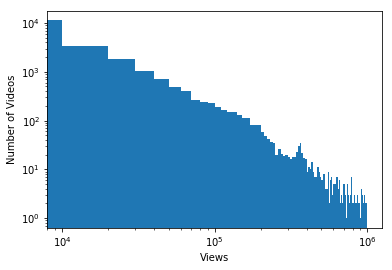

In [21]:
plt.hist(likesRDD, bins = [x * 10000 for x in range(100)])
plt.xlabel("Views")
plt.ylabel("Number of Videos")
plt.xscale("log", nonposx='clip')
plt.yscale("log", nonposy='clip')

The data of "dislike" votes is also having a "long-tail" at the right of the graph and following the power law.

Text(0,0.5,'Number of Videos')

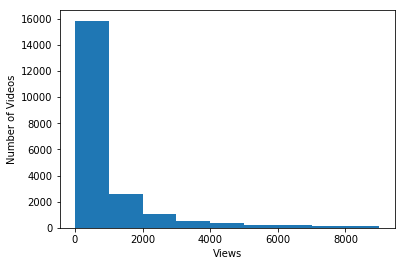

In [22]:
plt.hist(dislikesRDD, bins = [x * 1000 for x in range(10)])
plt.xlabel("Views")
plt.ylabel("Number of Videos")

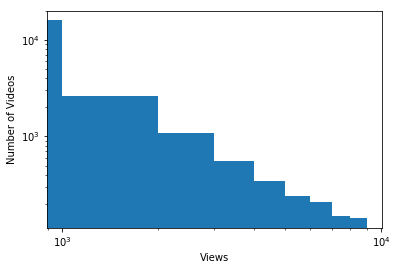

In [23]:
plt.hist(dislikesRDD, bins = [x * 1000 for x in range(10)])
plt.xlabel("Views")
plt.ylabel("Number of Videos")
plt.xscale("log", nonposx='clip')
plt.yscale("log", nonposy='clip')

### Stopwords in The Most Popular Categories
We can also check the unique words that each the most popular category has.

In [24]:

# Helper function for getting the decription of corresponding category ID
def getDescription(catID, rdd):
    return rdd.filter(lambda x: x[headerMap["category_id"]] == catID).map(lambda x: x[headerMap["description"]])

# Helper function for processing the data to do the word count in the description of videos
def processedDesc(rdd):
    return rdd.flatMap(lambda x: x.lower().split()).map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y)

entertainmentCatID = catNameIDMap["Entertainment"]
musicCatID = catNameIDMap["Music"]
styleCatID = catNameIDMap["Howto & Style"]

entertainmentDesc = getDescription(entertainmentCatID, rdd)
musicDesc = getDescription(musicCatID, rdd)
styleDesc = getDescription(styleCatID, rdd)

processedEnter = processedDesc(entertainmentDesc)
processedMusic = processedDesc(musicDesc)
processedStyle = processedDesc(styleDesc)

print(processedEnter.count(), processedMusic.count(), processedStyle.count())


23915 14118 16271


The most frequent words in the dataset are punctuations and some most common words in English like "the", "I", and "of", etc.
These most common words are called "stopwords". When doing natural language processing (NLP), the data needs to be preprocessed to filter out the stopwords to get rid of the interference of the common but somewhat meaningless words. As you can see in the below output, Although the definition of stopwords is context-based and application-based, the stopword sets in this dataset across different categories seem to highly overlap with each other.

In [25]:
print(processedEnter.takeOrdered(100, lambda x: -x[1]))
print()
print(processedMusic.takeOrdered(100, lambda x: -x[1]))
print()
print(processedStyle.takeOrdered(100, lambda x: -x[1]))

[('the', 25006), ('and', 15000), ('_', 13856), ('to', 11414), ('on', 10166), ('of', 9523), ('a', 8001), ('in', 5992), ('-', 5984), ('with', 5794), ('for', 5692), ('is', 4393), ('by', 3433), ('you', 3360), ('from', 3122), ('this', 2947), ('at', 2585), ('as', 2561), ('all', 2525), ('more', 2476), ('i', 2374), ('my', 2257), ('show', 2084), ('that', 2071), ('new', 1844), ('|', 1844), ('&', 1841), ('out', 1766), ('late', 1658), ('it', 1640), ('here:', 1568), ('your', 1513), ('about', 1469), ('his', 1452), ('us', 1419), ('her', 1349), ('are', 1332), ('videos', 1263), ('up', 1259), ('be', 1232), ('our', 1206), ('an', 1155), ('instagram:', 1151), ('live', 1151), ('have', 1149), ('twitter:', 1148), ('facebook:', 1140), ('we', 1105), ('video', 1091), ('was', 1066), ('me', 1054), ('what', 1046), ('their', 1035), ('watch', 988), ('has', 976), ('or', 949), ('subscribe', 947), ('star', 946), ('but', 941), ('will', 928), ('netflix', 858), ('get', 855), ('can', 839), ('website:', 822), ('voice', 813),

# Topic Modeling using Latent Dirichlet Allocation 

In the last section of this tutorial, I would like to introduce the usage of PySpark MLlib and the application of the topic modeling model called <a href="https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation">"Latent Dirichlet Allocation"</a>.<br>


Here I would like to do topic modeling on the description of the videos to classify them into 16 categories (the total number of categories in the dataset). Let's start with importing the essential libraries and the LDA model from the MLlib.

In [26]:
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.clustering import LDA, LDAModel

First step of the text handling is removing the stopwords from the corpus of descriptions. Here I arbitrarily set the number of stopwords to be 1000 and only consider the top 10000 most frequent words after removing the stopwords.

In [27]:
numStopWords = 1000
filteredRDD = (rdd.map(lambda x: x[headerMap["description"]])
                   .flatMap(lambda x: x.lower().split())
                   .filter(lambda x: not x.startswith("http") and not x.startswith("\\"))
                   .map(lambda x: (x, 1))
                   .reduceByKey(lambda x, y: x + y))

sortedFreq = sorted(filteredRDD.collect(), key = lambda x: -x[1])
uniqueWords = [x[0] for x in sortedFreq[numStopWords:numStopWords + 10000]]
print(uniqueWords[:100])
print()
print(len(uniqueWords))

['lipstick', 'helping', 'expert', 'nearly', 'picture', "world's", 'final', '20', 'large', 'fine', 'run', 'technology', 'them.', 'matter', '(and', 'tyler', 'hilarious', 'gilbert,', '(the', 'kitchen', 'sweet', 'four', 'educational', 'world’s', 'keeping', 'amazon:', 'science,', 'key', 'bravo:', 'honest', 'fallon', 'becoming', 'premier', 'b', 'shot', 'time.', 'commons', 'spend', 'mind', 'tim', 'coverage,', 'podcast', 'est', 'months', 'political', 'sarkis', 'patrons', '3d', 'delivered', 'launch', 'built', 'book:', 'store:', 'release', 'control', 'tells', 'women', 'now,', 'song:', 'amy', '30', 'edge', 'list', 'panther', 'short', 'sync', 'email:', 'smith,', 'main', 'giving', 'them,', 'views', 'lens:', 'meyers', 'tuned', 'recent', 'licensing', '12', 'lead', 'written', 'touch', '9', 'bright', 'professional', 'sean', 'theme', 'broadcast', 'bull', 'here!', '2017.', 'nfl:', 'ft.', 'richard', 'hang', 'title', 'teach', 'network:', 'often', 'island', 'per']

10000


In order to do the LDA modeling, the best way to process the data is transforming the data into SparseVector since the vector would be very sparse like what we did in the NLP assignment of 15688/388. First we need to build the word to vector index and index to word mapping so that we could map the words and indices in the sparse vector after training the model.

In [28]:
wordToIndex = {value: index for index, value in enumerate(uniqueWords)}
indexToWord = {index: value for index, value in enumerate(uniqueWords)}

SparseVector in Spark takes the size of the data as first argument and the data in iterable format.
https://spark.apache.org/docs/2.2.1/api/python/pyspark.mllib.html#pyspark.mllib.linalg.SparseVector

In [29]:
allDescriptions = (rdd.map(lambda x: x[headerMap["description"]].lower().split())
                      .map(lambda x: [wordToIndex[word] for word in x if word in wordToIndex]))

docVectors = allDescriptions.map(lambda x: SparseVector(len(uniqueWords), dict(collections.Counter(x))))
docVectors = docVectors.zipWithIndex().map(lambda x: [x[1], x[0]])
print(docVectors.count())
print(docVectors.take(1))

21965
[[0, SparseVector(10000, {106: 2.0, 122: 1.0, 126: 1.0, 403: 1.0, 460: 1.0, 474: 1.0, 528: 1.0, 594: 1.0, 609: 1.0, 1144: 1.0, 1269: 1.0, 1344: 1.0, 1364: 1.0, 1411: 1.0, 1812: 4.0, 1900: 1.0, 2085: 1.0, 2733: 3.0, 3449: 1.0, 3768: 1.0, 6744: 1.0, 7216: 1.0, 8547: 1.0, 8659: 1.0, 8660: 1.0, 8773: 1.0, 8885: 1.0, 8886: 1.0, 8978: 1.0, 9847: 1.0, 9980: 1.0})]]


To train the LDA model, simply call the ```train``` method on the data vector and specify the number of topics you want to categorize.
https://spark.apache.org/docs/2.2.1/api/python/pyspark.mllib.html#pyspark.mllib.clustering.LDA

In [30]:
ldaModel = LDA.train(docVectors, k = numOfCategories, seed = 20)

After training the LDA model, we can use ```topicsMatrix``` to acquire the inferred topics and the terms associated with each topic ordered by the weight of the each term.

In [31]:
topics = ldaModel.topicsMatrix()
for topic in range(3):
    print(topic)
    inds = np.argsort((topics[:,topic]))[-100:]
    print (sorted([indexToWord[i] for i in inds]))

0
['15', '1:', '20', '24-70mm', '_\\n\\ndisclaimer', '_\\n\\ni', '_\\n\\nstalk', 'anthem', "aren't", 'bar', 'biscuits:', 'boring', 'brands', 'cause', 'changed', 'clear', 'coat:', 'collider', 'da', 'data', 'derek', 'designs', 'dia', 'direct', 'discuss', 'driving', 'edit', 'episode,', 'face-cams:', 'facebook!', 'fav', 'final', 'french', 'gel', 'glitter', 'gmm', 'gossip', 'grow', 'guest', 'guys:', 'hacks:', 'happened', 'hip', 'holo', 'hop', 'info:', 'insight', 'intro', 'khz', 'law', 'lens:', 'like!', 'links.', 'live:', 'loose', 'mail', 'mailbag', 'media,', 'microphones', 'mountain', 'mythical', 'mythical:', 'mythicality', 'nails:', 'news.', 'newsroom', 'outro', 'own.', 'page', 'pass', 'peel-off', 'personalized', 'podcast:', 'polish:', 'polishes:', 'public', 'recorded', 'regularly', 'report', 'revealed', 'review:', 'rhett', 'rio', 'river', 'schmoedown', 'shipping', 'shotgun', 'something?', 'sounds', 'sports:', 'staff', 'submit', 'tip', 'tune', 'twitter!', 'wheel', 'with:', 'yeah,', 'zone',

The ```topicMatrix()``` method of LDA model will return a matrix with dimension N * Topics, where N is the total number of unique words we passed into the LDA constructor to train the model. topicMatrix will arrange words in each category from higher to lower weight. Though further analysis needs to be done to tell which topic is corresponding to which category, you should be able to get a sense of how topic modeling works.

# Summary

This tutorial highlighted several essential components of PySpark and its application in exploratory data analysis. Here I only showed the PySpark running in standalone mode. A programmer could easily perform big data processing using cluster mode and achieve high-throughput streaming data analysis.

If you wish to learn more details about the technologies mentioned in this tutorial, please refer to the following links.
1. RDD Programming Guide: https://spark.apache.org/docs/2.2.1/rdd-programming-guide.html
2. Spark Python API docs: https://spark.apache.org/docs/2.2.1/api/python/index.html
3. PySpark MLlib package docs: https://spark.apache.org/docs/2.2.1/api/python/pyspark.mllib.html
4. Seaborn: statistical data visualization: https://seaborn.pydata.org/
5. Kaggle: https://www.kaggle.com/